<a href="https://colab.research.google.com/github/samuel1sm/Project_MPCE/blob/main/TestesFaceClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Preparação do ambiente*


In [124]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
!pip install face_recognition
!pip install networkx
!pip install ISR
!pip install chinese-whispers

     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=65e03feeefe09ae9afc1c4d98524573b85b8723008e4b4f34b67e33aa85b8725
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models
     |████████████████████████████████| 86.3MB 43kB/s 
     |████████████████████████████████| 3.8MB 50.7MB/s 
     |████████████████████████████████| 450kB 48.2MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=8f51f598c25f65df0e77e456edb68829661c226df277c40cba6937bd2744048e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is in

In [ ]:
 import shutil
 shutil.rmtree('/imgs', ignore_errors=True)

!ln -s "/content/gdrive/My Drive/Datasets/ProjetoMPCE/TestDataset/Faces" imgs
if not os.path.exists("dataset"):
  os.mkdir("dataset")

!ln -s "/content/gdrive/My Drive/Datasets/ProjetoMPCE/Util" utils

In [127]:
data7s = os.listdir("imgs/")
data7s

['Faces', 'SortedImages.zip', 'data7.zip']

In [128]:
data7s = ['SortedImages.zip']

In [129]:
from zipfile import ZipFile

In [130]:
for i in data7s:
  with ZipFile(f"imgs/{i}", 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall("dataset/")

In [131]:
import glob 
images_path = glob.glob("dataset/*")


# *Codificando faces*




In [132]:
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os
from PIL import Image, ImageDraw
import numpy as np
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib
from ISR.models import RDN

from google.colab.patches import cv2_imshow

In [133]:
print("[INFO] quantifying faces...")
imagePaths = images_path
detection_method = "cnn"
encondings_path = "encodings/"
data = []

if not os.path.exists(encondings_path):
  os.mkdir(encondings_path)

[INFO] quantifying faces...


In [134]:
a = [images_path[10]]

In [ ]:
def recorte_antigo():
  # a = [images_path[14]]
  data = []

  for (i, imagePath) in enumerate(images_path):
    # load the input image and convert it from RGB (OpenCV ordering)
    # to dlib ordering (RGB)
    print(f"[INFO] processing {imagePath} , {i + 1}/{len(images_path)}")
    print(imagePath)
    image = cv2.imread(imagePath)
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height,width, _ = image.shape  
    boxes = face_recognition.face_locations(rgb,  model=detection_method)


    # cv2_imshow(image) 

    # boxes = [dlib.rectangle(top= top, right = right,bottom = bottom,left = left ) for top, right, bottom, left in boxes]

    for  top, right, bottom, left in boxes:
      # rect = dlib.rectangle(top= top, right = right,bottom = bottom,left = left )
      

      horizontal_padding = int((right - left) * padding_perc) +1
      vertical_padding = int((bottom - top) * padding_perc) +1


      top = 0 if top - horizontal_padding < 0 else top - horizontal_padding 
      bottom = height if bottom + horizontal_padding > height else bottom + horizontal_padding 
      left = 0 if left - vertical_padding  < 0 else left - vertical_padding 
      right = width if right + vertical_padding > width else right + vertical_padding 
      

      face = image[top :bottom , left :right ]

      face_landmarks = face_recognition.face_landmarks(face)
      h,w,_ = face.shape

      if len(face_landmarks) == 0:
        data.append(face)
        # cv2_imshow(face) 
        continue
      
      leftEyeCenter = np.array(face_landmarks[0]['left_eye']).mean(axis=0).astype("int")
      rightEyeCenter = np.array(face_landmarks[0]['right_eye']).mean(axis=0).astype("int")

      
      eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
              (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

      dY = rightEyeCenter[1] - leftEyeCenter[1]
      dX = rightEyeCenter[0] - leftEyeCenter[0]
      angle = np.degrees(np.arctan2(dY, dX))


      M = cv2.getRotationMatrix2D(eyesCenter, angle, 1)


      output = cv2.warpAffine(face, M, (w, h), flags=cv2.INTER_CUBIC)
      data.append(output)

      cv2_imshow(output) 


In [ ]:
padding_perc = 0.2
prediction = "utils/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(prediction)
fa = FaceAligner(predictor, desiredFaceWidth=256)

In [ ]:
# data = []

# for (i, imagePath) in enumerate(images_path):
# 	# load the input image and convert it from RGB (OpenCV ordering)
# 	# to dlib ordering (RGB)
#   print(f"[INFO] processing {imagePath} , {i + 1}/{len(images_path)}")
#   print(imagePath)
#   image = cv2.imread(imagePath)
#   rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   boxes = face_recognition.face_locations(rgb,  model=detection_method)

#   imgs = aling_faces(rgb, boxes)

#   encodings = []
#   # for img in imgs:
#   #   h,w,_ = img.shape
#   #   encodings.extend(face_recognition.face_encodings(img, [(0,w,h,0)]))

#   encodings = face_recognition.face_encodings(rgb, boxes) 

#   d = [{"imagePath": imagePath, "loc": box, "encoding": enc} 
#        for (box, enc) in zip(boxes, encodings)]

#   data.extend(d)

In [135]:
def extract_face_features(images_path, normalize: bool = True , print_key: bool = True ) -> list:
  data = []
  for (i, imagePath) in enumerate(a):
    if print_key:
      print(f"[INFO] processing {imagePath} , {i + 1}/{len(images_path)}")
      print(imagePath)

    image = cv2.imread(imagePath)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    boxes = face_recognition.face_locations(rgb,  model=detection_method)

    if normalize:
      rects = detector(gray, 2)

      encodings = []

      if len(boxes) == 0:
        continue

      rgbs = []
      final_boxes = []
      for i,box in enumerate(boxes):
        top, right, bottom, left = box
        rec = dlib.rectangle(top = top, right = right, bottom = bottom, left = left)
        faceAligned = fa.align(image, gray, rec)
        faceAligned = cv2.cvtColor(faceAligned, cv2.COLOR_BGR2RGB)
        # faceAligned = imutils.resize(faceAligned, width= right - left, height= bottom - top)
        # cv2_imshow(sr_img)
        # cv2_imshow(a)

        encodings.extend( face_recognition.face_encodings(faceAligned,[(0, 256,256,0)] ))
    else:
        encodings = face_recognition.face_encodings(rgb,boxes)



    d = [{"imagePath": imagePath, "loc": box, "encoding": enc} 
        for (box, enc) in zip(boxes, encodings)]

    data.extend(d)


In [ ]:
data = []

a = ["dataset/85.jpg"]
a = images_path
for (i, imagePath) in enumerate(a):
  print(f"[INFO] processing {imagePath} , {i + 1}/{len(images_path)}")
  print(imagePath)

  image = cv2.imread(imagePath)
  rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  boxes = face_recognition.face_locations(rgb,  model=detection_method)

  encodings = face_recognition.face_encodings(rgb,boxes)

  # rects = detector(gray, 2)

  # encodings = []
  # print(len(boxes))
  # if len(boxes) == 0:
  #   continue

  # rgbs = []
  # final_boxes = []
  # for i,box in enumerate(boxes):
  #   top, right, bottom, left = box
  #   rec = dlib.rectangle(top = top, right = right, bottom = bottom, left = left)
  #   faceAligned = fa.align(image, gray, rec)
  #   faceAligned = cv2.cvtColor(faceAligned, cv2.COLOR_BGR2RGB)
  #   # faceAligned = imutils.resize(faceAligned, width= right - left, height= bottom - top)
  #   # cv2_imshow(sr_img)
  #   # cv2_imshow(a)

  #   encodings.extend( face_recognition.face_encodings(faceAligned,[(0, 256,256,0)] )) 



  d = [{"imagePath": imagePath, "loc": box, "encoding": enc} 
       for (box, enc) in zip(boxes, encodings)]

  data.extend(d)

[INFO] processing dataset/64.jpg , 1/91
dataset/64.jpg
[INFO] processing dataset/47.jpg , 2/91
dataset/47.jpg
[INFO] processing dataset/74.jpg , 3/91
dataset/74.jpg
[INFO] processing dataset/66.jpg , 4/91
dataset/66.jpg
[INFO] processing dataset/52.jpg , 5/91
dataset/52.jpg
[INFO] processing dataset/15.jpg , 6/91
dataset/15.jpg
[INFO] processing dataset/23.jpg , 7/91
dataset/23.jpg
[INFO] processing dataset/57.jpg , 8/91
dataset/57.jpg
[INFO] processing dataset/89.jpg , 9/91
dataset/89.jpg
[INFO] processing dataset/42.jpg , 10/91
dataset/42.jpg
[INFO] processing dataset/71.jpg , 11/91
dataset/71.jpg
[INFO] processing dataset/10.jpg , 12/91
dataset/10.jpg
[INFO] processing dataset/34.jpg , 13/91
dataset/34.jpg
[INFO] processing dataset/1.jpg , 14/91
dataset/1.jpg
[INFO] processing dataset/50.jpg , 15/91
dataset/50.jpg
[INFO] processing dataset/54.jpg , 16/91
dataset/54.jpg
[INFO] processing dataset/0.jpg , 17/91
dataset/0.jpg
[INFO] processing dataset/38.jpg , 18/91
dataset/38.jpg
[INFO

In [ ]:
print(len(data))
print("[INFO] serializing encodings...")
f = open(f"data.pickle", "wb")
f.write(pickle.dumps(data))
f.close()

238
[INFO] serializing encodings...


# *Clusterizando faces*


In [ ]:
from sklearn.cluster import DBSCAN,KMeans
from imutils import build_montages
import numpy as np
import argparse
import pickle
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import dlib 

In [ ]:
imagePaths = images_path
jobs = -1
detection_method = "cnn"

In [ ]:
print("[INFO] loading encodings...")
# data = pickle.loads(open(encondings_path, "rb").read())
df = pd.DataFrame(data)
encodings =[dlib.vector(i) for i in df["encoding"].values.tolist()]

[INFO] loading encodings...


In [ ]:
df

imagePath  ...                                           encoding
0    dataset/64.jpg  ...  [-0.14492037892341614, 0.0994400903582573, 0.0...
1    dataset/64.jpg  ...  [-0.09061884135007858, 0.14418213069438934, 0....
2    dataset/64.jpg  ...  [-0.12975989282131195, 0.02412472665309906, 0....
3    dataset/64.jpg  ...  [-0.17003342509269714, 0.06374116986989975, 0....
4    dataset/64.jpg  ...  [-0.09765877574682236, 0.07666822522878647, 0....
..              ...  ...                                                ...
233  dataset/55.jpg  ...  [-0.09866609424352646, 0.046045634895563126, 0...
234  dataset/55.jpg  ...  [-0.11451585590839386, 0.1146259605884552, 0.1...
235  dataset/13.jpg  ...  [-0.08272145688533783, 0.0871429517865181, 0.0...
236  dataset/13.jpg  ...  [-0.10934659838676453, 0.06103091686964035, 0....
237  dataset/13.jpg  ...  [-0.1658046394586563, 0.010956630110740662, 0....

[238 rows x 3 columns]

**Chinese Whispers**

In [ ]:
labels = dlib.chinese_whispers_clustering(encodings, 0.5)
df["cluster"] = labels

**K-Means**

In [ ]:
# def kmeans(numero_de_clusters, dados):
#     modelo = KMeans(n_clusters=numero_de_clusters, random_state=0)
#     modelo.fit(dados)
#     return [numero_de_clusters,modelo.inertia_], modelo.labels_


# max = 50
# p1=np.array(kmeans(2, encodings)[0])
# p2=np.array(kmeans(max, encodings)[0])



# distance = 0
# qtd_cluster = 0
# finded_clusters = 0

# result_final = 0
# joelho =[]
# plt.figure(figsize=(18,10))
# x = [p1[0],p2[0]]
# y = [p1[1],p2[1]]
# plt.plot(x, y, c="r")
# x = []
# y = []

# for i in range(13,13+1):

#     result,clusters = kmeans(i, encodings)
#     p3=np.array(result)
#     d=np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
    
#     joelho.append(result)
#     x.append(result[0])
#     y.append(result[1])
#     plt.plot(result[0],result[1], 'r*', c = 'b')

#     if abs(d) > distance:
#       distance = abs(d)
#       qtd_cluster= i
#       result_final = result
#       finded_clusters = clusters

# df["cluster"] = finded_clusters
# print(qtd_cluster)
# plt.plot(p1[0],p1[1], 'r*', c = 'g')
# plt.plot(p2[0],p2[1], 'r*', c = 'g')
# plt.plot(result_final[0],result_final[1], 'r*', c = 'black')
# plt.plot(x, y)


# *Verificando Clusterização Imagens*


In [ ]:
qtd_cluster= len(df["cluster"].unique())
qtd_cluster

45

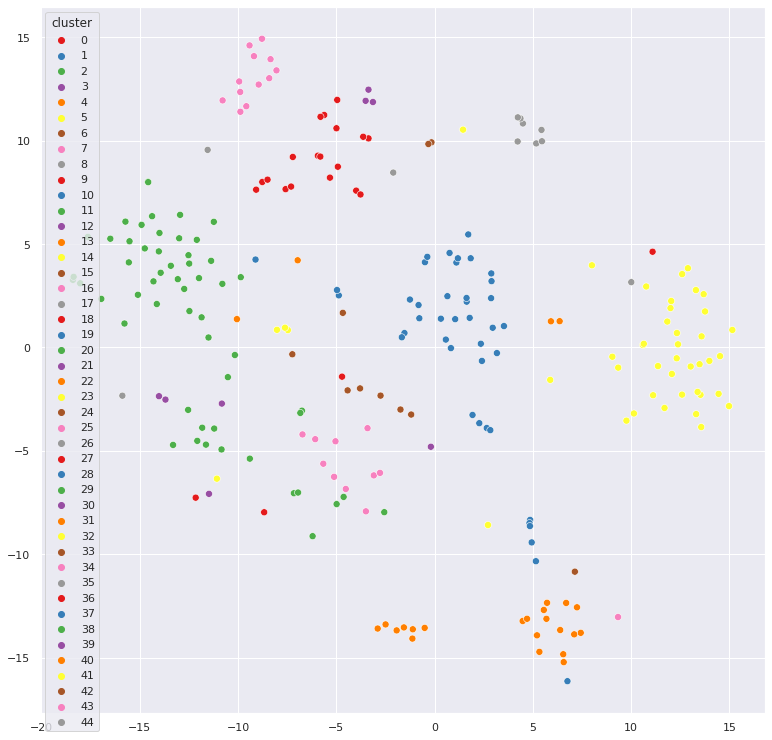

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()
visualizacao = tsne.fit_transform(encodings)
import seaborn as sns

sns.set(rc={'figure.figsize': (13, 13)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.scatterplot(x=visualizacao[:, 0],
               y=visualizacao[:, 1],
               hue=df["cluster"],
               palette=sns.color_palette('Set1',qtd_cluster), s = 50)

# *Gerar grafo*


In [ ]:
import networkx as nx

In [ ]:
# filtro = df.groupby(by="imagePath").apply(lambda a: a["cluster"].tolist())
graph_df = df.drop(columns = ["loc", "encoding"])
graph_df = graph_df.merge(graph_df, on = "imagePath")
graph_df = graph_df.query("cluster_x < cluster_y")
# filtro3 = filtro2.loc[filtro2[["cluster_x", "cluster_y"]].apply(lambda a: a["cluster_x"] != a["cluster_y"], axis = 1)]
graph_df.drop_duplicates(inplace= True)
# graph_df.query("cluster_x == 1").apply(lambda a: print(a["imagePath"],a["cluster_x"],a["cluster_y"]),axis =1)

In [ ]:
occurrences = graph_df.groupby(by="cluster_x").apply(lambda a:( a["cluster_y"].tolist()))

In [ ]:
graph_df = graph_df.sort_values(by=['cluster_x', 'cluster_y']).drop_duplicates(subset=['cluster_x', 'cluster_y']).reset_index(drop=True)

In [ ]:
result = []
for i,occurrence in enumerate(occurrences):
  fitered = np.unique(np.array(occurrence), return_counts = True)
  result.extend(fitered[1])

graph_df["occurrence"] = result

In [ ]:
self_pointg_df = {"imagePath" : [], "cluster_x" : [],"cluster_y" : [], "occurrence" : []}
for cluster in df["cluster"].unique():
  im_path = df[df["cluster"] == cluster]["imagePath"].values[0]
  self_pointg_df["imagePath"].append(im_path)
  self_pointg_df["cluster_x"].append(cluster)
  self_pointg_df["cluster_y"].append(cluster)
  self_pointg_df["occurrence"].append(1)

aux_df = pd.DataFrame(self_pointg_df)
graph_df = pd.concat([graph_df, aux_df])

In [ ]:
edge_label = {}
graph_df.apply(lambda a: edge_label.update({(a["cluster_x"],a["cluster_y"]) : a["occurrence"]}), axis = 1)

0     None
1     None
2     None
3     None
4     None
      ... 
40    None
41    None
42    None
43    None
44    None
Length: 187, dtype: object

In [ ]:
G = nx.from_pandas_edgelist(graph_df, source="cluster_x", target = "cluster_y", edge_attr=["occurrence"] )

In [ ]:
df_img_exemple = df.drop_duplicates("cluster").sort_values("cluster").reset_index(drop = True)

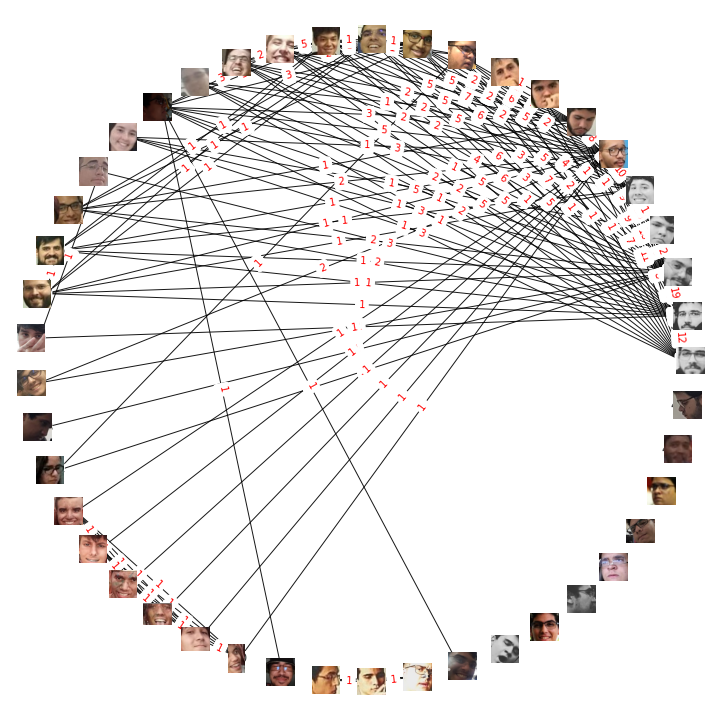

In [ ]:
fig=plt.figure(figsize=(13, 13))
ax=plt.subplot(111)
ax.set_aspect('equal')

pos=nx.circular_layout(G)

nx.draw(G,pos,edge_color='black',width=1,linewidths=1,\
node_size=1,node_color='pink',alpha=0.9,\
labels={node:node for node in G.nodes()}, ax =ax)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_label,font_color='red', ax = ax)


trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

piesize=0.03 # this is the image size
p2=piesize/2.0
for n in G:
    xx,yy=trans(pos[n]) # figure coordinates
    xa,ya=trans2((xx,yy)) # axes coordinates
    a = plt.axes([xa-p2,ya-p2, piesize, piesize])

    line = df_img_exemple.iloc[n]
    image = cv2.imread(line["imagePath"])
    (top, right, bottom, left) = line["loc"]
    face = image[top:bottom, left:right]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)

    a.imshow(face)
    a.axis('off')

nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_label,font_color='red', ax = ax)

plt.axis('off')
plt.show()
print()

# *Plotando Imagens*


In [ ]:
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

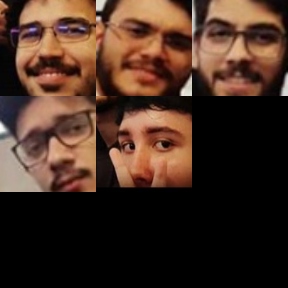

In [ ]:
filtro = df[df["imagePath"] == "dataset/65.jpg"]

filtro.reset_index(inplace=True)
faces = []
for i,line in filtro.iterrows():
    image = cv2.imread(line["imagePath"])
    (top, right, bottom, left) = line["loc"]
    face = image[top:bottom, left:right]
    face = cv2.resize(face, (96, 96))
    faces.append(face)
  
montage = build_montages(faces, (96, 96), (3, 3))[0]
cv2_imshow(montage)


qtd: 1


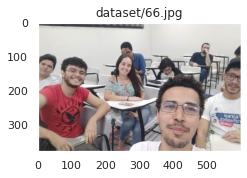

In [ ]:
clusters_list = [6,5]
filtro = df[df["cluster"].isin(clusters_list)].copy()
filtro= filtro.groupby("imagePath").filter(lambda x: True if len(x["cluster"].unique()) == len(clusters_list) else False)
filtro = filtro.drop_duplicates(subset=['imagePath']).copy()
filtro.reset_index(inplace=True)
print(f"qtd: {len(filtro)}")
plt.figure(figsize=(8,14))
plt.rcParams["axes.grid"] = False

columns = 2
for i,line in filtro.iterrows():
      
    plt.subplot(((int(len(filtro)) +1)/columns),columns,i+1)
    img = cv2.imread(line["imagePath"])
    # cv2_imshow(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.title(line["imagePath"])
plt.show()

2


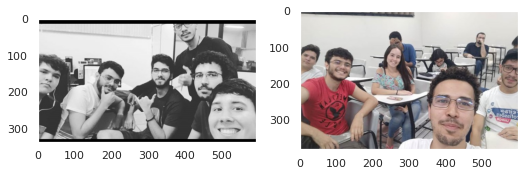

In [ ]:
filtro = df[df["cluster"] == 3].copy()

filtro.reset_index(inplace=True)
plt.figure(figsize=(18,20))
plt.rcParams["axes.grid"] = False

print(len(filtro))

columns = 4
for i,line in filtro.iterrows():
    
    plt.subplot(int(len(filtro)/columns)+1,columns,i+1)
    img = cv2.imread(line["imagePath"])
    # cv2_imshow(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

[INFO] faces for face ID: 0


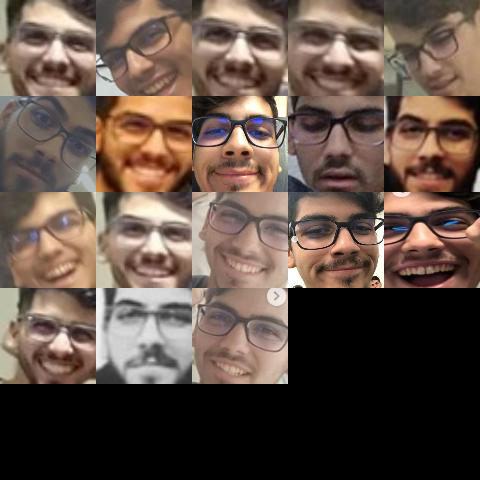

[INFO] faces for face ID: 1


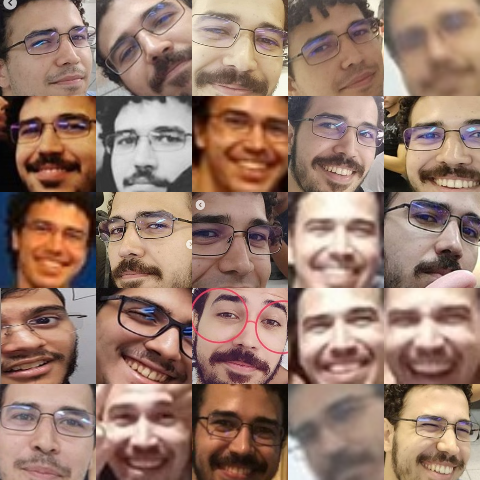

[INFO] faces for face ID: 2


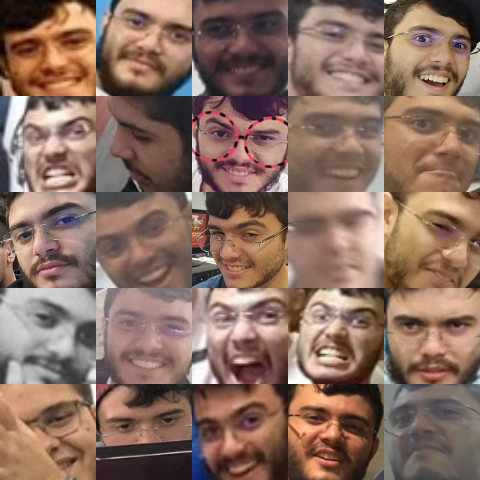

[INFO] faces for face ID: 3


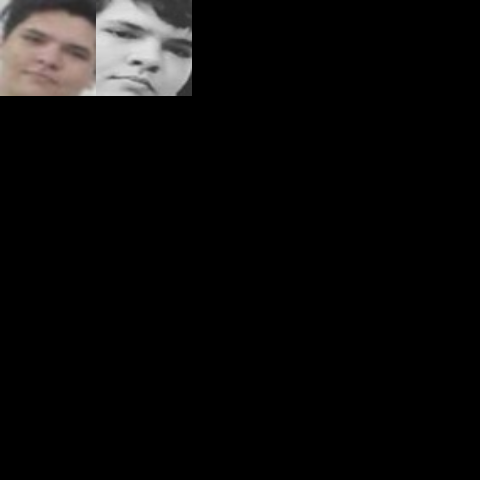

[INFO] faces for face ID: 4


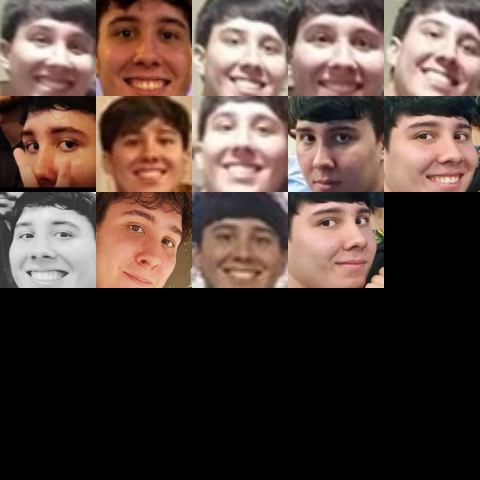

[INFO] faces for face ID: 5


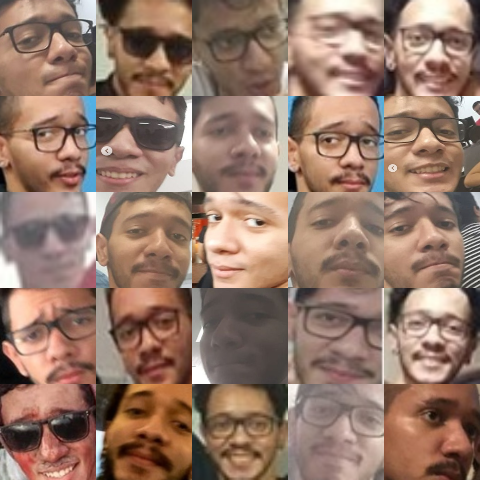

[INFO] faces for face ID: 6


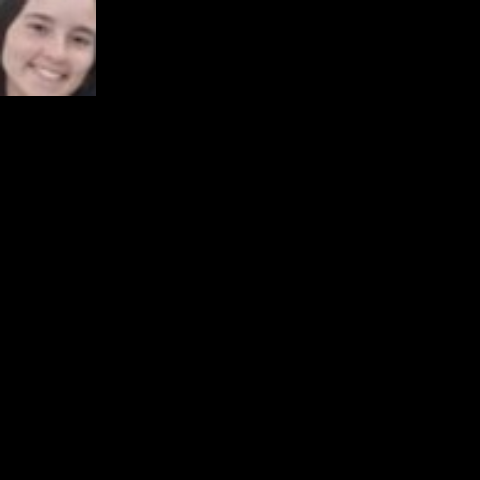

[INFO] faces for face ID: 7


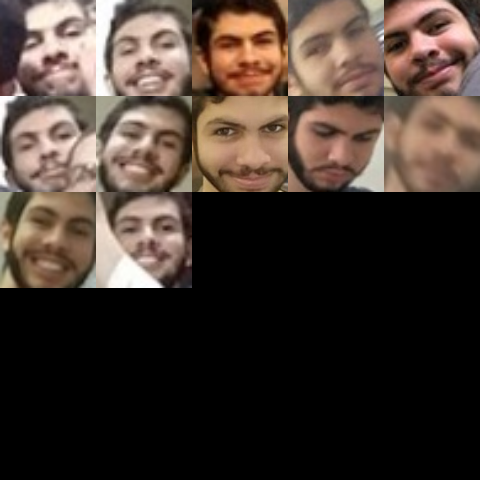

[INFO] faces for face ID: 8


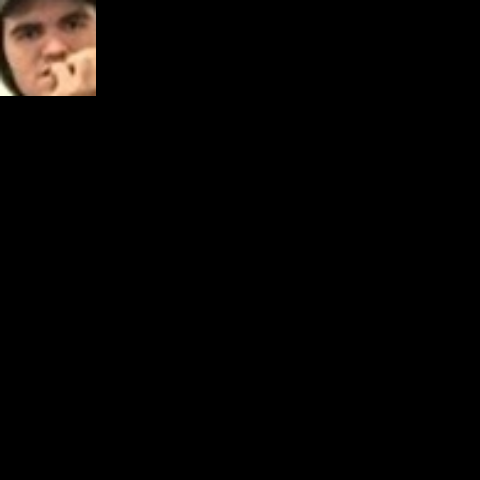

[INFO] faces for face ID: 9


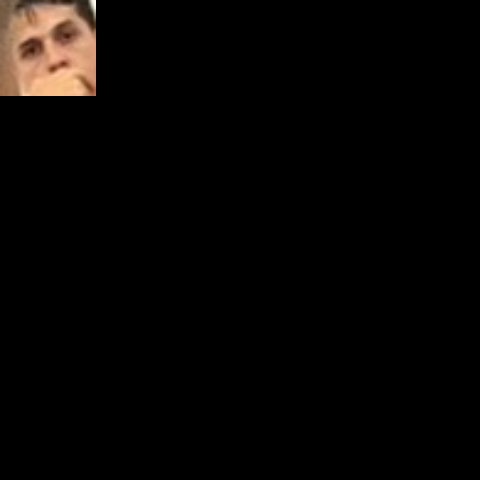

[INFO] faces for face ID: 10


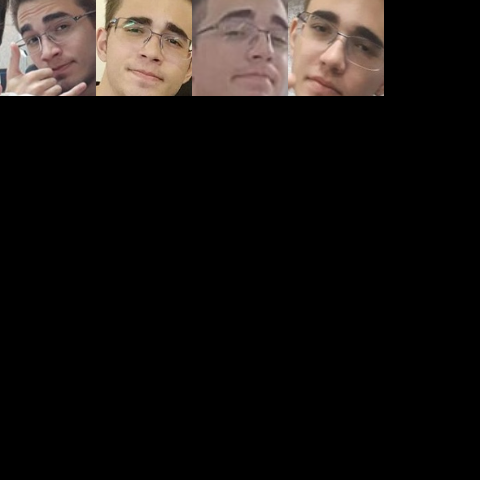

[INFO] faces for face ID: 11


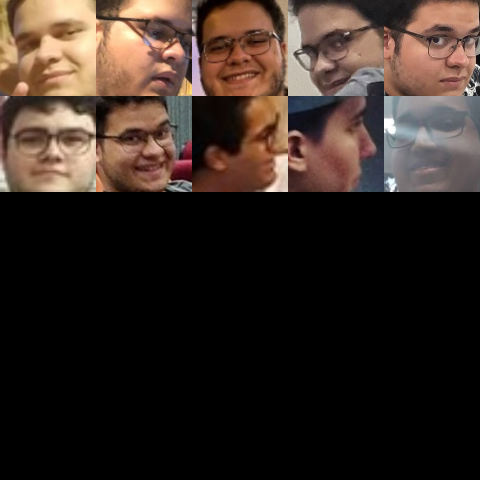

[INFO] faces for face ID: 12


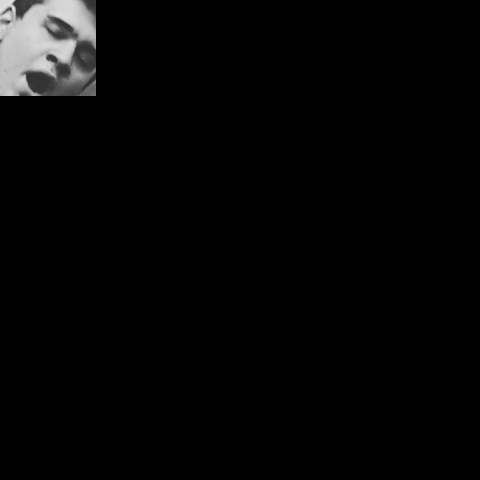

[INFO] faces for face ID: 13


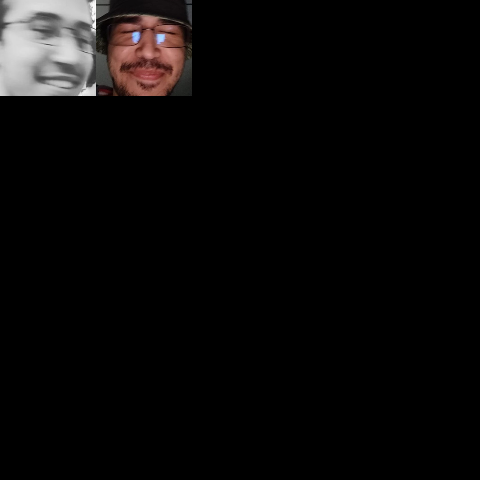

[INFO] faces for face ID: 14


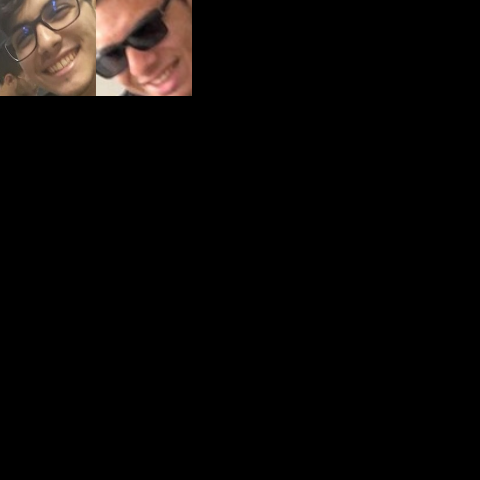

[INFO] faces for face ID: 15


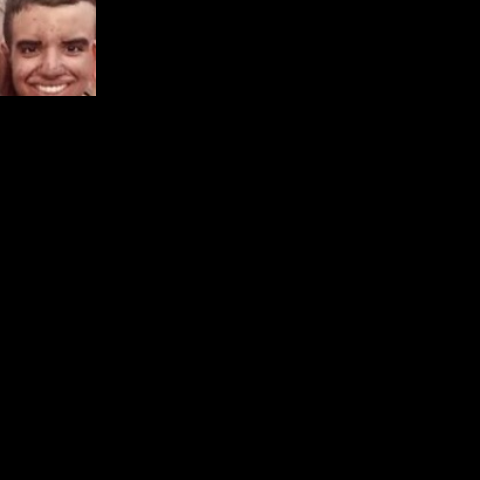

[INFO] faces for face ID: 16


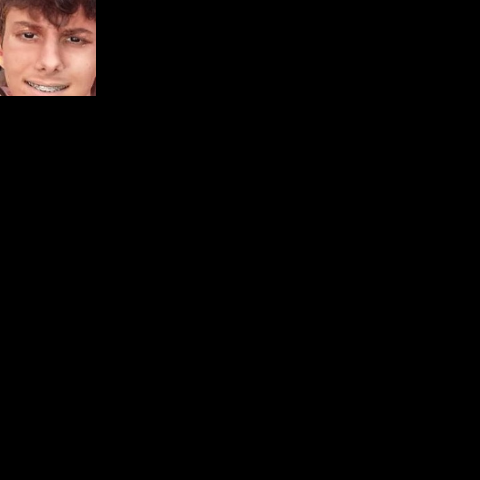

[INFO] faces for face ID: 17


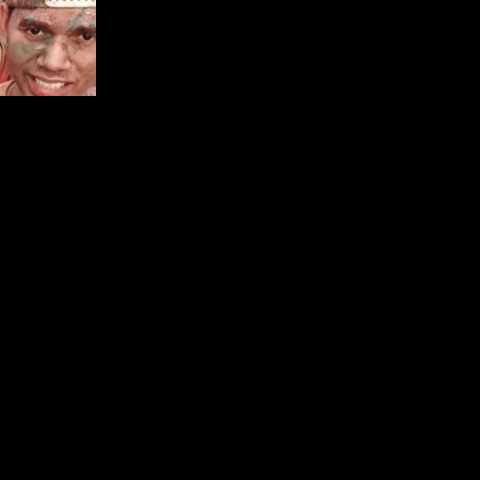

[INFO] faces for face ID: 18


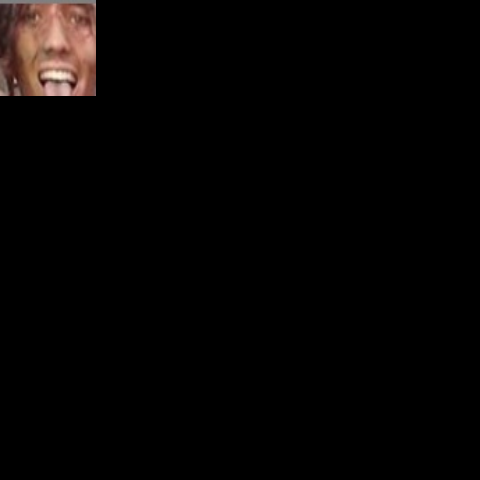

[INFO] faces for face ID: 19


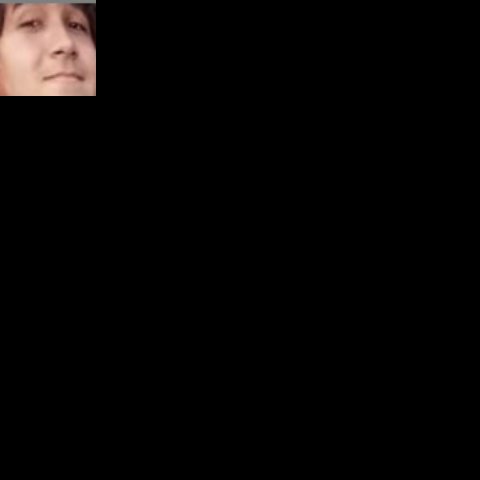

[INFO] faces for face ID: 20


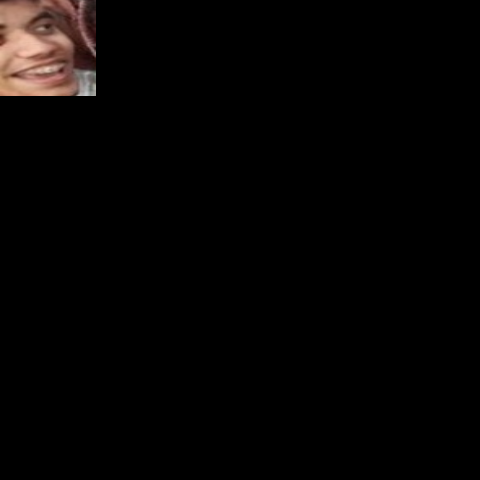

[INFO] faces for face ID: 21


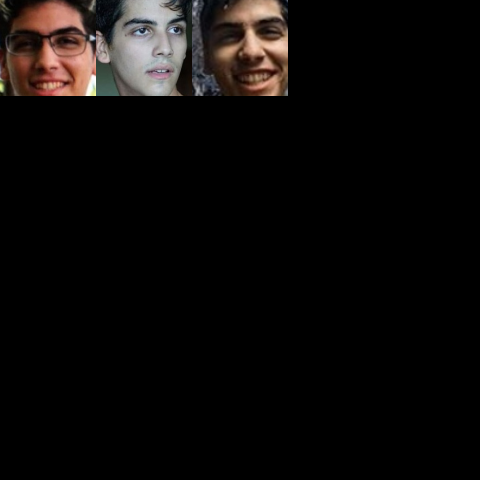

[INFO] faces for face ID: 22


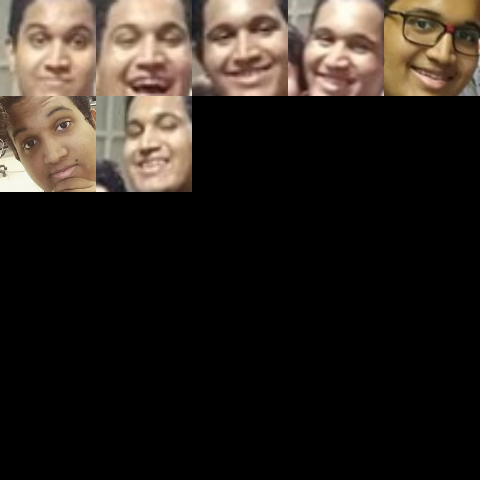

[INFO] faces for face ID: 23


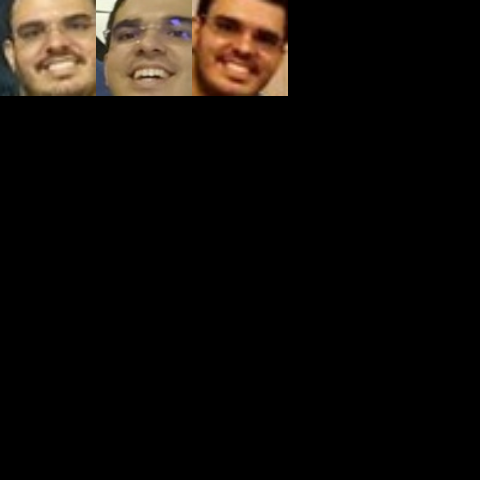

[INFO] faces for face ID: 24


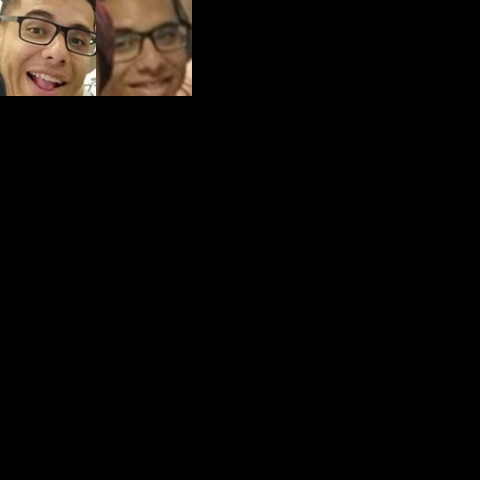

[INFO] faces for face ID: 25


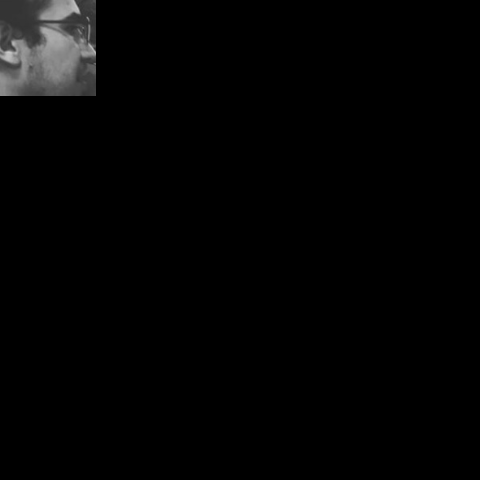

[INFO] faces for face ID: 26


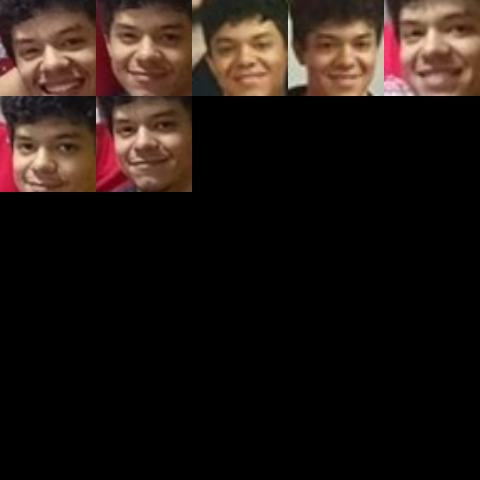

[INFO] faces for face ID: 27


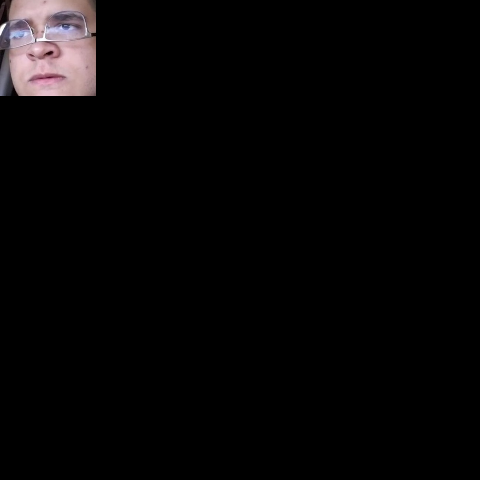

[INFO] faces for face ID: 28


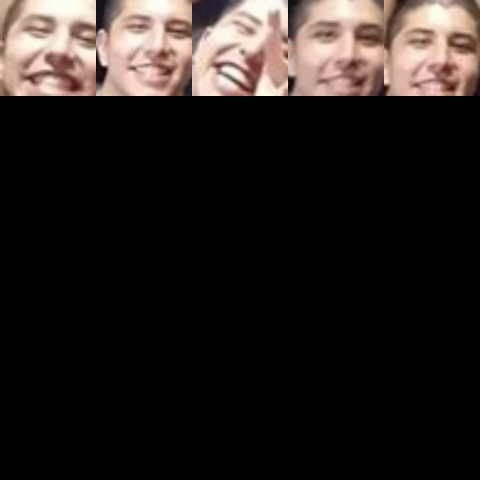

[INFO] faces for face ID: 29


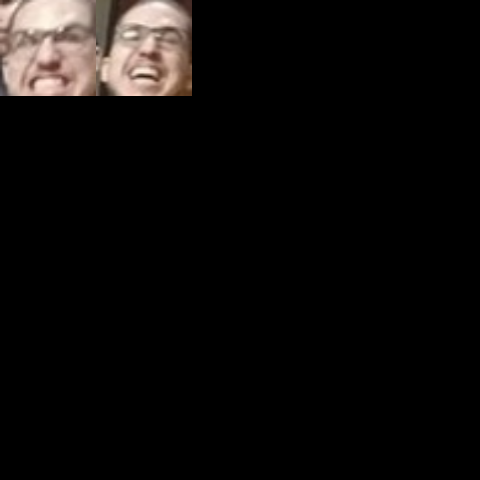

[INFO] faces for face ID: 30


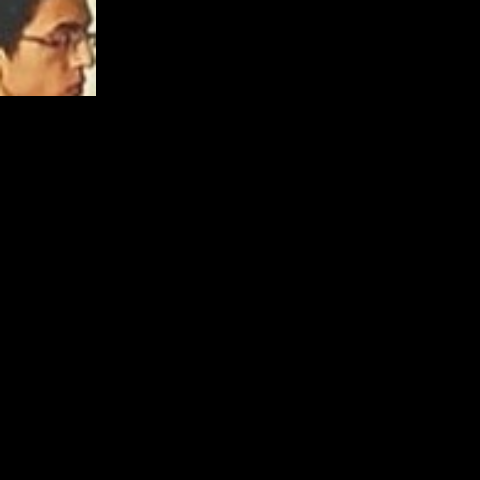

[INFO] faces for face ID: 31


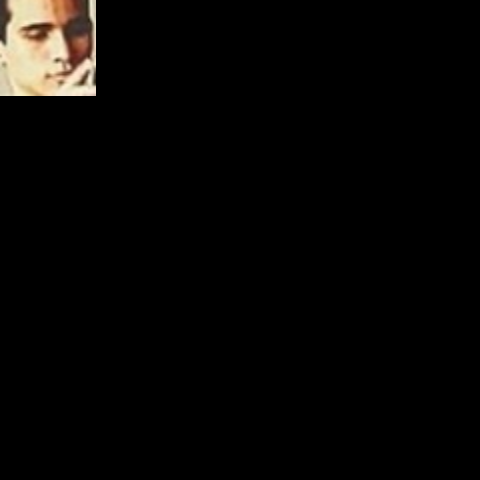

[INFO] faces for face ID: 32


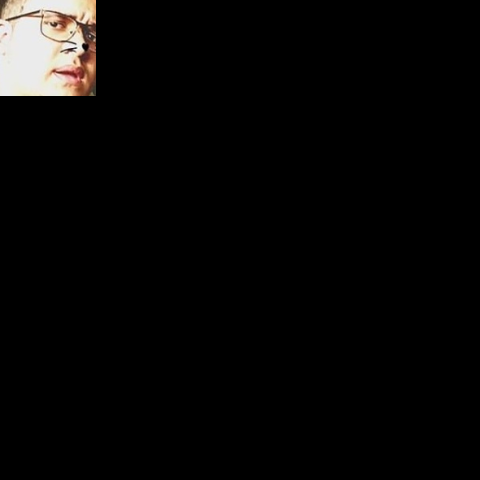

[INFO] faces for face ID: 33


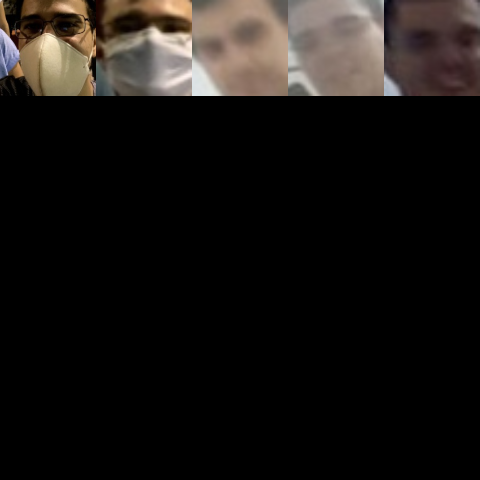

[INFO] faces for face ID: 34


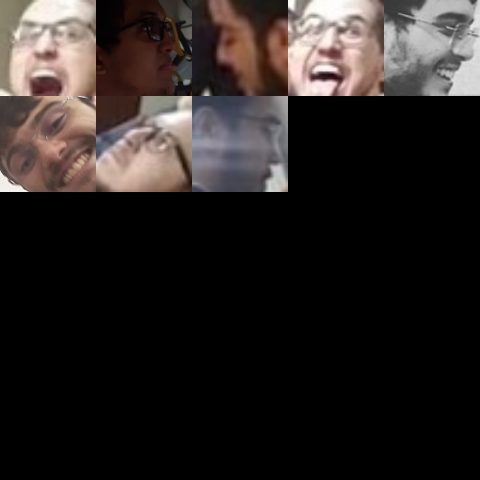

[INFO] faces for face ID: 35


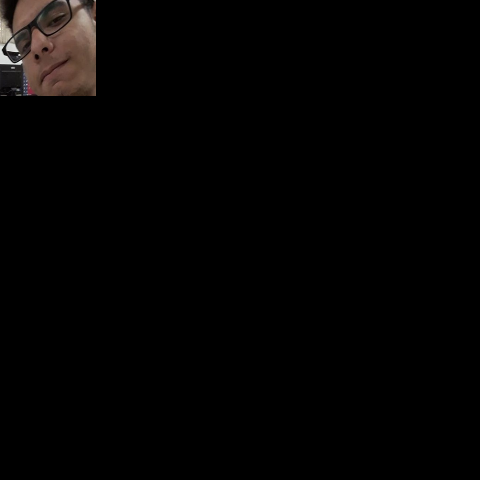

[INFO] faces for face ID: 36


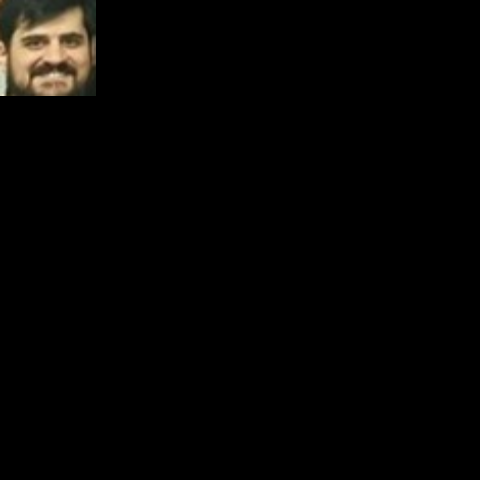

[INFO] faces for face ID: 37


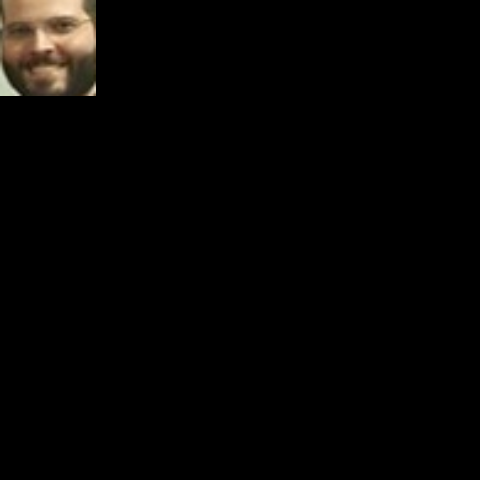

[INFO] faces for face ID: 38


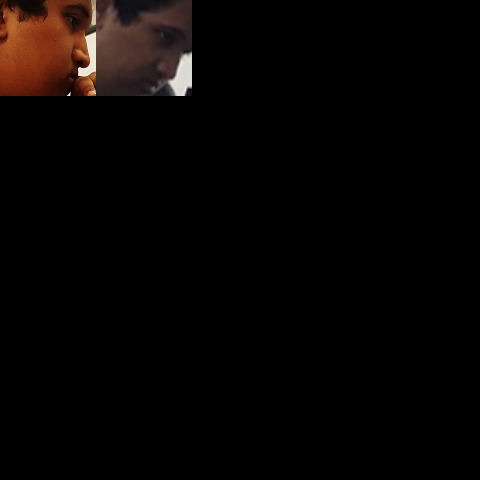

[INFO] faces for face ID: 39


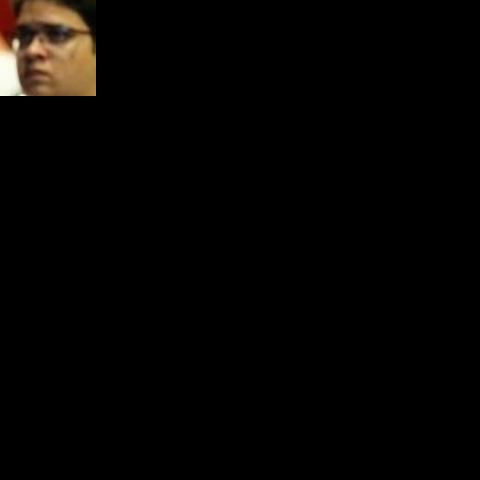

[INFO] faces for face ID: 40


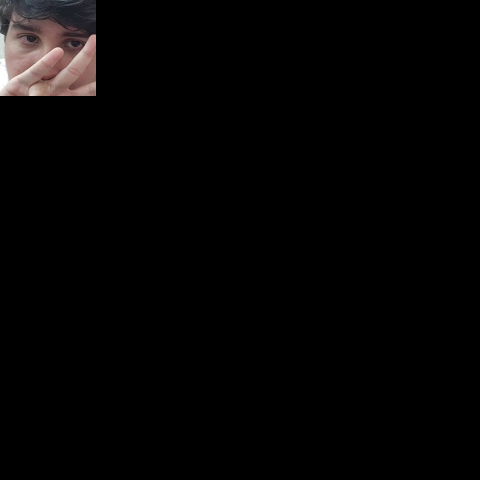

[INFO] faces for face ID: 41


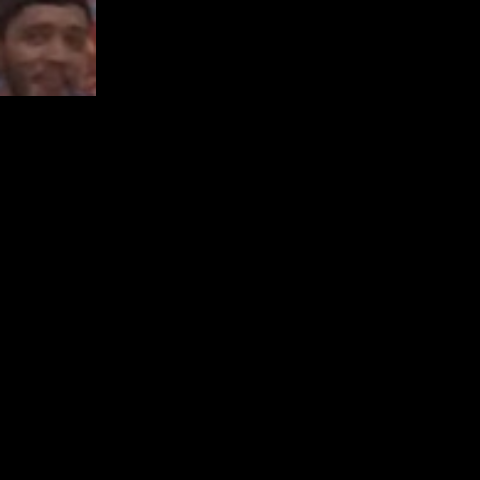

[INFO] faces for face ID: 42


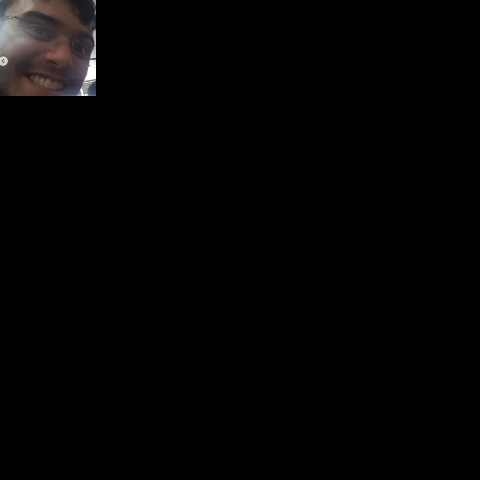

[INFO] faces for face ID: 43


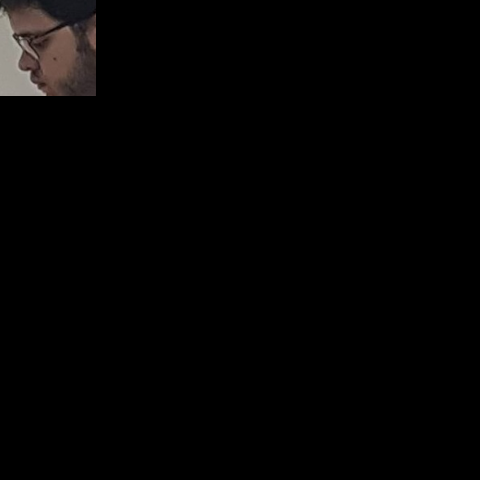

[INFO] faces for face ID: 44


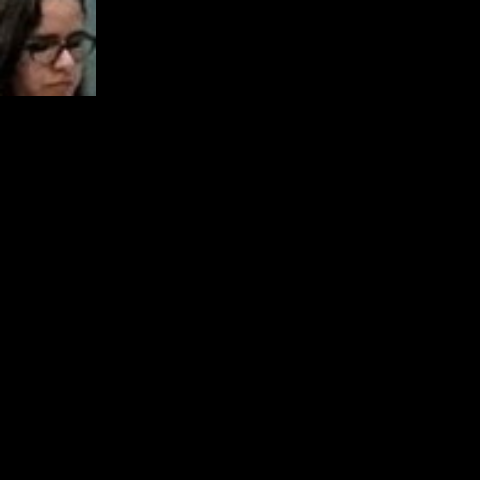

In [ ]:
for labelID in np.sort(df["cluster"].unique()):
  print("[INFO] faces for face ID: {}".format(labelID))
  idxs = df[df["cluster"] == labelID]
  idx = idxs.sample(min(25, len(idxs)))

  faces = []
  for i,line in idx.iterrows():
    image = cv2.imread(line["imagePath"])
    (top, right, bottom, left) = line["loc"]
    face = image[top:bottom, left:right]
    face = cv2.resize(face, (96, 96))
    faces.append(face)

  montage = build_montages(faces, (96, 96), (5, 5))[0]

	# show the output montage
  title = "Face ID #{}".format(labelID)
  title = "Unknown Faces" if labelID == -1 else title
  cv2_imshow(montage)


# Grafo teste


In [5]:
import pandas as pd
import networkx as nx
from chinese_whispers import chinese_whispers
import numpy as np
import dlib
import matplotlib.pyplot as plt

In [26]:
def get_graph_edges_value(G , attribute: str = "value"):
  return nx.get_edge_attributes(G,attribute)

In [86]:
def plot_graph_clustering(G,clusters_data: pd.DataFrame = None, attribute : str = "value", ):
  edge_label = get_graph_edges_value(G, attribute)
  pos=nx.spring_layout(G)

  if type(clusters_data) == pd.DataFrame:
    clusters_data['labels']=pd.Categorical(clusters_data['labels'])

    nx.draw(G, with_labels=True,pos=pos, node_color=clusters_data['labels'].cat.codes, cmap=plt.cm.Set1, node_size=500)
  else:
    nx.draw(G,pos ,with_labels=True)

  a = nx.draw_networkx_edge_labels(G,pos = pos,edge_labels=edge_label,font_color='red')
  plt.show()

In [103]:
def create_graph(graph_data, plot_graph : bool = False, source: str = "node_x", target: str = "node_y", edge_attr=["value"],attribute: str = "value"  ):
  if not type(graph_data) == pd.DataFrame:
    graph_data = pd.DataFrame(graph_data)

  G = nx.from_pandas_edgelist(graph_data, source=source, target = target, edge_attr=edge_attr )
  if plot_graph:
    plot_graph_clustering(G, attribute = attribute)
  
  return G

In [113]:
def cluster_cw(G):
  edge_label = get_graph_edges_value(G)
  chinise_whipers_list = [(k[0], k[1], edge_label[k]) for k in edge_label]
  c2 = dlib.chinese_whispers(chinise_whipers_list)

  results_df = pd.DataFrame()
  results_df['ID'] = range(len(G)+1)
  results_df['labels'] = c2
  results_df = results_df.set_index('ID')
  results_df = results_df.reindex(G.nodes())
  labels = np.unique(results_df['labels'])
  results_df['labels']=pd.Categorical(results_df['labels'])

  for i in G.nodes():
    G.nodes()[i]["labels"] = results_df.loc[i]["labels"]
  
  return G,results_df

In [121]:
def join_results(G, results_df, super_results_df):
  G = G.copy()
  p = s_results_df.reset_index()
  p.apply(lambda a: results_df["labels"].replace({a["ID"] : a["labels"]},inplace = True),axis = 1)

  for i in G.nodes():
    G.nodes()[i]["labels"] = results_df.loc[i]["labels"]
  
  return G,results_df

In [108]:
def create_super_graph(G, results_df, plot_graph : bool = False):
  labels = results_df["labels"].unique().to_list()

  clusters_infos = {}
  df_nodes_in_clusters = results_df.reset_index().groupby("labels")

  for label in labels:
    sub_df = df_nodes_in_clusters.get_group(label)["ID"].to_list()
    gy = G.subgraph(sub_df)
    aux_df = pd.DataFrame(gy.edges(data=True))
    aux_df[2] = aux_df[2].apply(lambda a: a['value'])
    clusters_infos[label] = {"min" : min(aux_df[2]), "avg" : aux_df[2].mean()}
    edges_connection = {}

  for label in labels:
    cluster_nodes = df_nodes_in_clusters.get_group(label)["ID"].to_list()
    # print(cluster_nodes)
    for cn in cluster_nodes:
      # print(cn)
      for n in G.neighbors(cn):
        if n not in cluster_nodes:
          first_cluster = G.nodes()[cn]["labels"]
          second_cluster = G.nodes()[n]["labels"]

          tuple_key =  tuple(sorted([first_cluster , second_cluster]))
          nodes_connection = tuple(sorted([cn , n]))
          edge_value = G.get_edge_data(cn,n)['value']
          if not (edge_value >= clusters_infos[first_cluster]["min"] or edge_value >= clusters_infos[second_cluster]["min"]):
            continue
          if not tuple_key in edges_connection:
            edges_connection[tuple_key] = {"combinations" : [nodes_connection], "values" : [edge_value]}
          elif nodes_connection not in edges_connection[tuple_key]["combinations"] :
            edges_connection[tuple_key]["combinations"].append(nodes_connection)
            edges_connection[tuple_key]["values"].append(edge_value)

  super_graph_data = {"node_x" : [],"node_y" : [],"value" : [] }

  for i in labels:
    super_graph_data["node_x"].append(i)
    super_graph_data["node_y"].append(i)
    super_graph_data["value"].append(0)


  for key in edges_connection:
    node_sum = sum(edges_connection[key]['values'])  
    c1, c2 = key
    if node_sum >= clusters_infos[c1]["avg"] or node_sum >= clusters_infos[c2]["avg"]:
      super_graph_data["node_x"].append(c1)
      super_graph_data["node_y"].append(c2)
      super_graph_data["value"].append(max(edges_connection[key]['values']))
  
  print(super_graph_data)
  super_graph_data = pd.DataFrame(super_graph_data)
  return create_graph(super_graph_data, plot_graph), super_graph_data 

In [17]:
c = {"node_x" : [1,1,1,1,2,2,4,4,6,13,13,13,15,15,12,12,11,11,11,11,9,9,9,7,7], 
     "node_y" : [2,3,4,5,3,4,5,6,5,12,15,14,12,14,14,11,8,10,7,9,8,10,7,8,10], 
     "value" : [0.6,0.1,0.35,0.2,0.28,0.1,0.6,0.25,0.2,0.6,0.4,0.3,0.4,0.35,0.5,0.2,0.5,0.1,0.6,0.5,0.4,0.3,0.4,0.2,0.2]}

c = pd.DataFrame(c)

{'node_x': [1, 2, 4, 3, 1], 'node_y': [1, 2, 4, 3, 2], 'value': [0, 0, 0, 0, 0.35]}


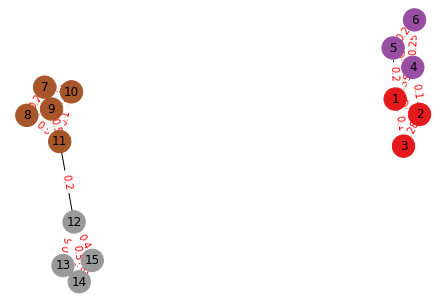

-------------


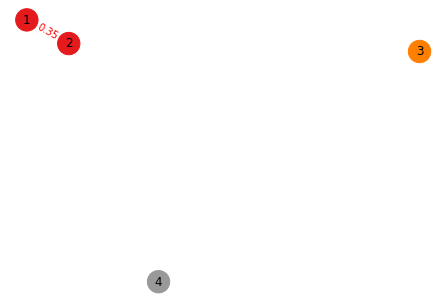

-------------


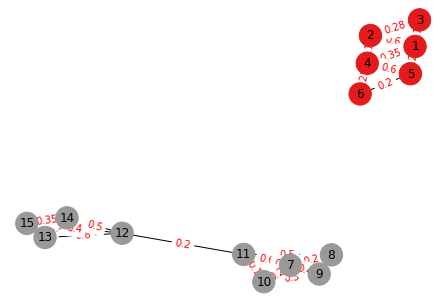

In [123]:
G = create_graph(c, False)
G,results_df = cluster_cw(G)
# plot_graph_clustering(G,results_df)
s_G, s_df = create_super_graph(G,results_df, False)
plot_graph_clustering(G,results_df)
print("-------------")

s_G,s_results_df = cluster_cw(s_G)
plot_graph_clustering(s_G,s_results_df)
print("-------------")
f_G,f_results_df = join_results(G, results_df, s_results_df)
plot_graph_clustering(f_G,f_results_df)
